### A. Import Mock Data

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
# using a dummy portfolio consisting of the Ken French 30 Industry Portfolio 
ind = pd.read_csv('data/ind30_m_vw_rets.csv', header = 0, index_col = 0, parse_dates = True) / 100
ind.index = pd.to_datetime(ind.index, format = '%Y%m')
ind.columns = ind.columns.str.rstrip()

In [3]:
train = ind['1965':'1995']
test = ind['1995': '1998']

# create a mock portfolio of selected indices
sectors = ['Food', 'Smoke', 'Hlth', 'Chems', 'Fin', 'Rtail']
returns = train[sectors]

In [4]:
returns.describe()

,Food,Smoke,Hlth,Chems,Fin,Rtail
count,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000
mean,0.012104,0.014168,0.011725,0.009363,0.011183,0.010286
std,0.047060,0.055094,0.052718,0.053747,0.052941,0.057830
min,-0.175500,-0.217900,-0.204600,-0.280000,-0.211200,-0.291400
25%,-0.011350,-0.020925,-0.018650,-0.025200,-0.021400,-0.024825
50%,0.010600,0.013350,0.011250,0.008500,0.012500,0.005650
75%,0.036100,0.049275,0.042850,0.041800,0.047400,0.047625
max,0.204000,0.225400,0.295200,0.200100,0.211000,0.270700


### I. Estimate an AR(1)-EGARCH(1,1) model for each asset 𝑖, and obtain parameter estimates, conditional sigmas and residuals

{Xt} is called an autoregressive process of order k with an GARCH noise of order p, q, in short

AR(k)-EGARCH(p,q) process, 

if for t = 0, ±1, ±, 2, . . . :

>$$Xt = ϕ_1X_{t−1} + · · · + ϕ_kX_{t−k} + ε_t$$

>$$ε_t = σ_tv_t$$

where $v_t$ is a strong white noise (iid (0,1)), and $σ_t$ satisfies the recurrence equation:

>$$ ln(σ_t^2) = \alpha_0 + \alpha_1 g({v_{t-1}}) + . . . . \alpha_p g({v_{t-p}}) + \beta_1 ln({\sigma_{t-1}} ^2) + . . . . \beta_q ln({\sigma_{t-q}} ^2)$$

where 

>$$g(v_t) = \theta v_t + \delta (|v_t| - E|v_t|)$$

Here, we are following the AR(1)-EGARCH(1,1)

Hence, our process is:

>$$Xt = ϕ_1X_{t−1} + ε_t$$

>$$ε_t = σ_tv_t$$

>$$ ln(σ_t^2) = \alpha_0 + \alpha_1 g({v_{t-1}}) + \beta_1 ln({\sigma_{t-1}} ^2) $$

>$$g(v_t) = \theta v_t + \delta (|v_t| - E|v_t|)$$


In [5]:
from statsmodels.tsa.stattools import adfuller
returns.dropna(inplace=True)
adfuller(returns['Food'])

ipykernel_launcher:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(-17.877807575970774,
 3.010433781841381e-30,
 0,
 371,
 {'1%': -3.4480996560263386,
  '5%': -2.8693621113224137,
  '10%': -2.570937038891028},
 -1145.821472374507)

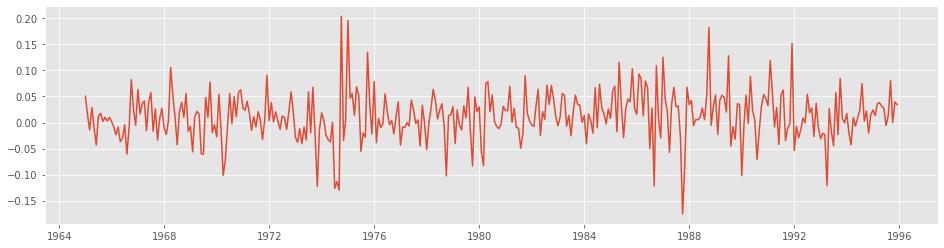

In [6]:
from statsmodels.tsa.stattools import acf, pacf


plt.subplots(figsize=(16,4))
plt.plot(returns['Food'])

In [7]:
def stationarity(df):
    import statsmodels.api as sm
    acf_p=acf(df, nlags=10)
    pacf_p=pacf(df, nlags=10)
    f, ax = plt.subplots(2, 2, sharey=True, figsize=(17,6))
    ax[0,0].plot(df)
    ax[0,0].set_title('Sharing Y axis')
    
    ax[0,1].plot(acf_p)
    ax[0,1].axhline(y=0, linestyle='--', color='gray')
    ax[0,1].axhline(y=1.96/(np.sqrt(len(df))), linestyle='--', color='gray')
    ax[0,1].axhline(y=-1.96/(np.sqrt(len(df))), linestyle='--', color='gray')            
    ax[0,1].axhline(y=0, linestyle='--', color='gray')
    ax[0,1].set_title(str('ACF plot'))
    
    ax[1,0].plot(pacf_p)
    ax[1,0].axhline(y=0, linestyle='--', color='gray')
    ax[1,0].axhline(y=1.96/(np.sqrt(len(df))), linestyle='--', color='gray')
    ax[1,0].axhline(y=-1.96/(np.sqrt(len(df))), linestyle='--', color='gray')            
    ax[1,0].axhline(y=0, linestyle='--', color='gray')
    ax[1,0].set_title(str('PACF plot'))
    

    sm.qqplot(df, line='s', ax=ax[1,1])
    ax[1,1].set_title(str('QQ plot'))
    
    rs=adfuller(df)
    print (rs)
    
    plt.show()
    

C:\Users\unnik\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
(-17.877807575970774, 3.010433781841381e-30, 0, 371, {'1%': -3.4480996560263386, '5%': -2.8693621113224137, '10%': -2.570937038891028}, -1145.821472374507)


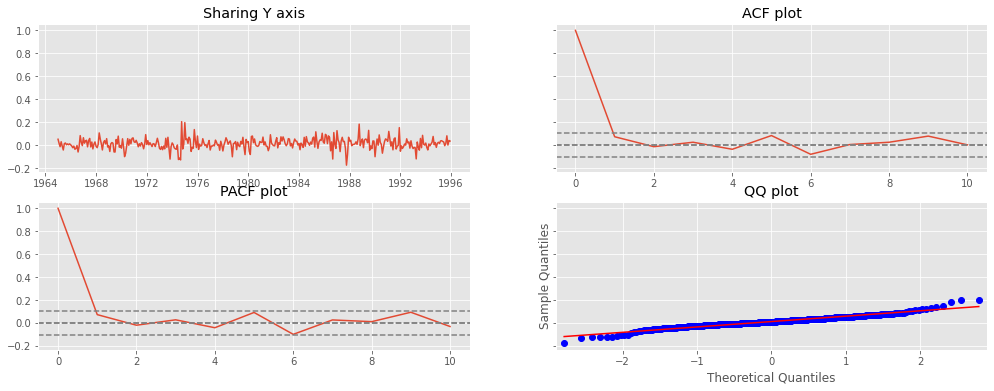

In [8]:
stationarity(returns['Food'])

In [9]:
pip install armagarch

Note: you may need to restart the kernel to use updated packages.


In [10]:
import armagarch as ag


# define mean, vol and distribution
meanMdl = ag.ARMA(order = {'AR':1,'MA':0})
volMdl = ag.garch(order = {'p':1,'q':1}) # need doubts clarified regarding E-GARCH
distMdl = ag.normalDist()

# create a model
model = ag.empModel(returns['Food'].to_frame(), meanMdl, volMdl, distMdl)

# fit model
model.fit()

# get the conditional mean
Ey = model.Ey

# get conditional variance
ht = model.ht
cvol = np.sqrt(ht)

# get standardized residuals
stres = model.stres

# make a prediction of mean and variance over next 3 days.
pred = model.predict(nsteps = 1)


                         ARMA-GARCH estimation results                          
Dep Variable:                    Food    R-squared:                        0.0
Mean Model:                      ARMA    Adj. R-squared:                 -0.01
Vol Model:                      GARCH    Log Likelihood:                 613.9
Distribution:                Gaussian    AIC:                         -1217.79
Method:                            ML    BIC:                          -1198.2
                                         Num obs:                          372
Date:                Tue, Mar 30 2021    Df Residuals:                     368
Time:                        15:47:50    Df Model:                           4
                                                                                
                                   Mean Model                                   
                            Estimate          Std. Error              t-stat
------------------------------------------------

In [11]:
from arch import arch_model

In [12]:
m = arch_model(returns['Food'], vol= "EGARCH", p=1, o=0, q=1, dist='t')
res = m.fit(update_freq=5)

Iteration:      5,   Func. Count:     44,   Neg. LLF: -296.35730085235105
Iteration:     10,   Func. Count:     79,   Neg. LLF: -636.0098100635641
Iteration:     15,   Func. Count:    109,   Neg. LLF: -636.023657025175
Optimization terminated successfully    (Exit mode 0)
            Current function value: -636.0236570251702
            Iterations: 15
            Function evaluations: 109
            Gradient evaluations: 15
C:\Users\unnik\Anaconda3\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002209. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


### II. Calculating Standardized residuals and conditional volatility

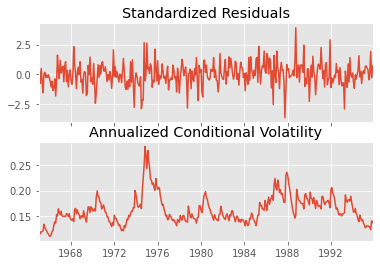

In [31]:
fig = res.plot(annualize="M")

In [13]:
forecasts = res.forecast()

In [14]:
print(forecasts.mean.iloc[-3:])
print(forecasts.residual_variance.iloc[-3:])
print(forecasts.variance.iloc[-3:])

                 h.1
1995-10-01       NaN
1995-11-01       NaN
1995-12-01  0.011644
               h.1
1995-10-01     NaN
1995-11-01     NaN
1995-12-01  0.0016
               h.1
1995-10-01     NaN
1995-11-01     NaN
1995-12-01  0.0016


In [35]:
residuals = res.resid

### III. Fit univariate skewed-t distributions to each vector of residuals by MLE.

C:\Users\unnik\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


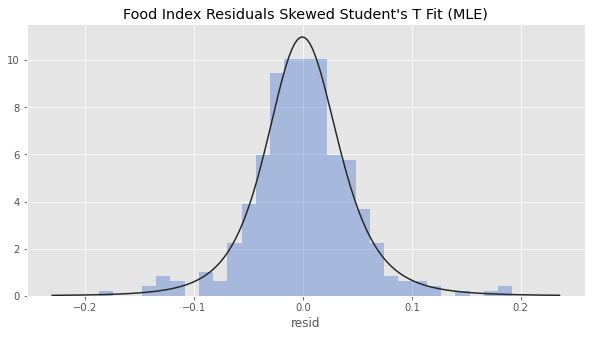

In [39]:
from scipy.stats import nct

plt.figure(figsize=(10, 5))
plt.title("Food Index Residuals Skewed Student's T Fit (MLE)")
sns.set_palette('muted')
sns.distplot(residuals, fit=nct,kde=False)
plt.savefig('skewed_std.png')